"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
import pandas as pd

sys.path.append('/media/bigdata/projects/pytau')
import pytau

import itertools as it
from tqdm import tqdm

In [2]:
data_dir = '/media/bigdata/firing_space_plot/changepoint_mcmc/ipython_notebooks/'
spikes = np.load(os.path.join(data_dir,'km36_day1_dig3_suc.spikes.npy'))
lasers = np.load(os.path.join(data_dir,'km36_day1_dig3_suc.laser.npy'))

#data_dir = '/media/fastdata/VF350_SUC1_190327_121132_repacked/'
# dat = ephys_data(data_dir)
# dat.get_spikes()
# dat.firing_rate_params = dat.default_firing_params
# dat.get_firing_rates()

In [3]:
# data_vec = np.squeeze(np.array(dat.spikes))

In [4]:
data_vec = spikes[np.where(lasers)[0]]
time_lims = [2000,4000]
data_vec = data_vec[...,time_lims[0]:time_lims[1]]

In [5]:
bin_width = 50
spike_array = np.sum(np.reshape(data_vec,(*data_vec.shape[:2],-1,bin_width)),axis=-1)[4:]
print(spike_array.shape)

(11, 41, 40)


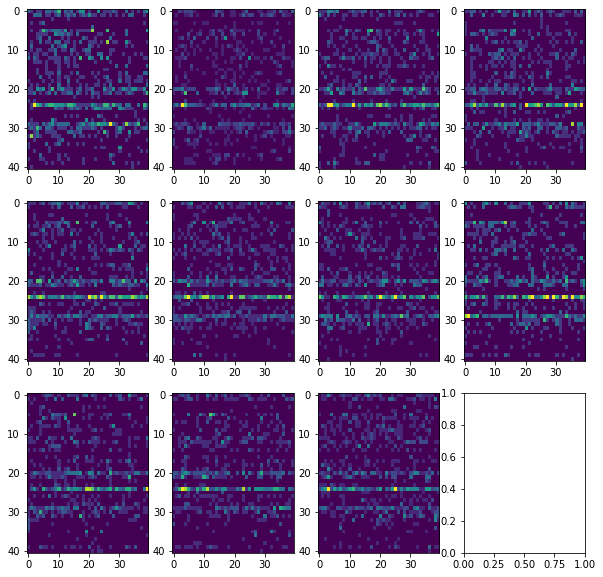

In [6]:
fig,ax = visualize.gen_square_subplots(len(spike_array), figsize = (10,10));
for this_dat, this_ax in zip(spike_array, ax.flatten()):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')

In [14]:
state_list = range(6,7)#range(2,7)
comps_list = range(2,3)#range(2,5)
iters = list(it.product(state_list, comps_list))

In [16]:
elbo_list = []
model_list = []
approx_list = []
fit = 40000
samples = 20000

In [17]:
#single_taste_poisson_trial_switch(spike_array,switch_components,states)
for this_iter in tqdm(iters):
    model = pytau.changepoint_model.single_taste_poisson_trial_switch(spike_array, this_iter[1], this_iter[0])
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        #trace = approx.sample(draws=samples)
    
    model_list.append(model)
    approx_list.append(approx)
    elbo_list.append(-approx.hist[-1])

  0%|          | 0/1 [00:00<?, ?it/s]

Finished [100%]: Average Loss = 14,339
100%|██████████| 1/1 [01:10<00:00, 70.73s/it]


In [18]:
param_array = np.array(iters)
elbo_frame = pd.DataFrame(dict(
                states = param_array[:,0],
                components = param_array[:,1],
                elbo = elbo_list))

## ==== Models with Top 3 ELBO ====

In [19]:
elbo_frame.sort_values('elbo', ascending=False)

,states,components,elbo
0,6,2,-14387.616686


In [20]:
best_model_ind = np.argsort(elbo_list)[-1]#np.argmax(elbo_list)
best_model = model_list[best_model_ind]
best_approx = approx_list[best_model_ind]

In [21]:
# pm.model_to_graphviz(best_model)

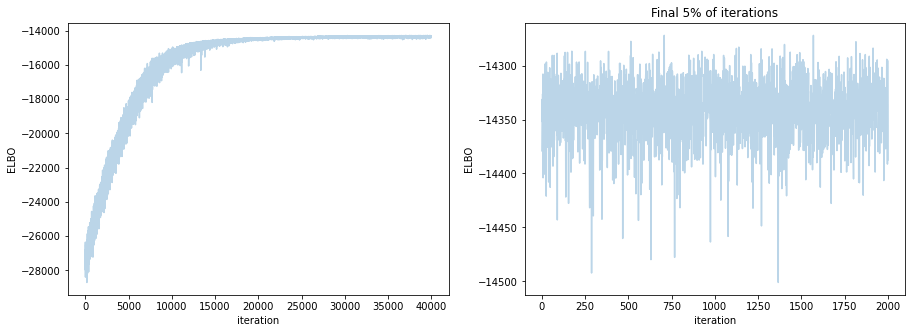

In [22]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-best_approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-best_approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [23]:
with best_model:
    trace = best_approx.sample(draws=samples)

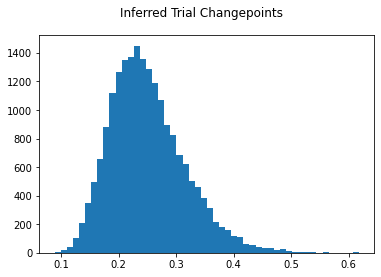

In [24]:
for dist in trace['tau_trial'].T:
    plt.hist(dist,bins = 50);
plt.suptitle('Inferred Trial Changepoints');

In [25]:
# Plot changes in emission
mean_selected_trial_lambda = np.mean(trace['selected_trial_lambda'],axis=0).swapaxes(0,1)
print(mean_selected_trial_lambda.shape)

(6, 41, 11)


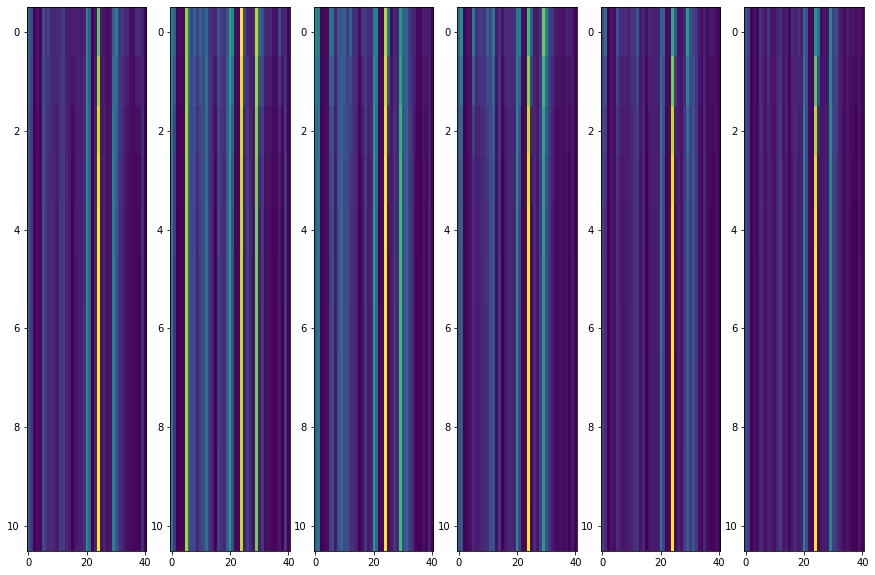

In [26]:
fig,ax = plt.subplots(1,len(mean_selected_trial_lambda), figsize=(15,10))
for this_dat, this_ax in zip(mean_selected_trial_lambda, ax):
    this_ax.imshow(this_dat.T, interpolation='nearest', aspect='auto')

In [27]:
tau_stack = trace['tau']
int_tau = np.vectorize(np.int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=0)[0])

Text(0, 0.5, 'Trial Number')

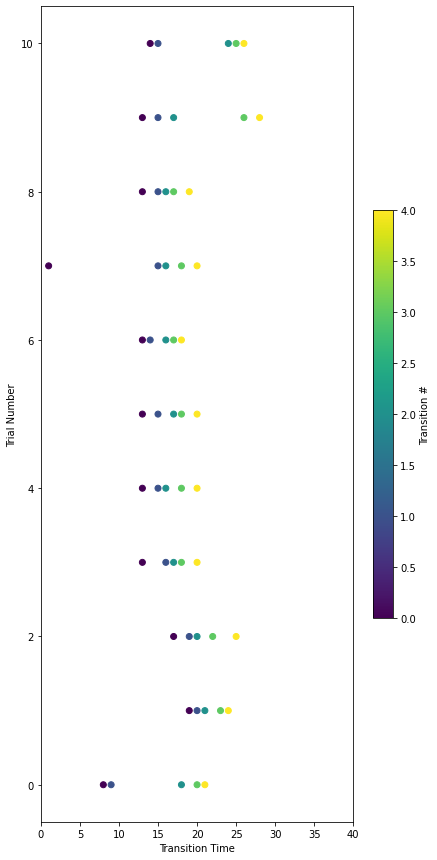

In [28]:
fig,ax = plt.subplots(figsize = (7,15))
for num, vals in enumerate(mode_tau):
    im = ax.scatter(vals,[num]*len(vals), c = range(len(vals)))
plt.xlim(0,spike_array.shape[-1])
plt.colorbar(im, shrink = 0.5, label = 'Transition #')
plt.xlabel('Transition Time')
plt.ylabel('Trial Number')

In [29]:
trial_switch_ind = np.squeeze(stats.mode(np.vectorize(np.int)(trace['tau_trial']))[0])
trial_membership = tt.nnet.sigmoid(np.arange(len(mode_tau)) - trial_switch_ind).eval()

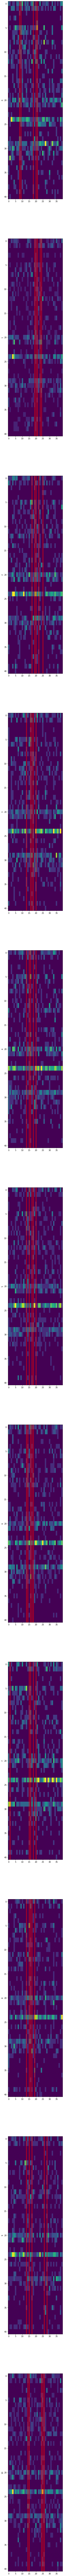

In [30]:
fig,ax = plt.subplots(len(spike_array),1, figsize = (5,240))
for ind in range(mode_tau.shape[0]):
    this_tau = mode_tau[ind]
    this_dat = spike_array[ind]
    this_ax = ax.flatten()[ind]
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.vlines(this_tau, -0.5, this_dat.shape[0]-0.5, 
                   color = 'red', linewidth = 5, alpha = 0.5)
    this_ax.set_ylabel(ind)

## Save model

In [61]:
print(trace['state_lambda'].nbytes/1e6)
print(trace['state_lambda'].shape)

78.72
(20000, 41, 2, 6)


In [62]:
percs = np.linspace(0,100,12)
lambda_percs = np.percentile(trace['state_lambda'], percs, axis=0)

In [63]:
print(lambda_percs.shape)
print(lambda_percs.nbytes/1e6)

(12, 41, 2, 6)
0.047232


In [42]:
temp_outs = [model, approx, trace['state_lambda'], trace['tau'], spike_array]
varnames = ['model', 'approx', 'lambda', 'tau', 'data']

In [38]:
save_path = '/media/bigdata/firing_space_plot/changepoint_mcmc/ipython_notebooks/save_size_test'

In [45]:
num = 3
this_names = varnames[:num+1]
save_name = "_".join(this_names)
print(save_name)

model_approx_lambda_tau


In [49]:
for num in range(len(varnames)):
    this_names = varnames[:num+1]
    this_dat = temp_outs[:num+1]
    
    save_name = "_".join(this_names)
    out_dict = dict(zip(this_names,this_dat))
    
    with open(os.path.join(save_path, save_name + '.pkl'), 'wb') as buff:
             pickle.dump(out_dict, buff)

## PCA of firing colored by trial membership

In [154]:
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import NMF, PCA

In [122]:
lim_inds = [int(x/25) for x in time_lims]
firing_array = np.squeeze(dat.firing_array)[...,lim_inds[0]:lim_inds[1]]

In [132]:
#spike_array_long = spike_array.swapaxes(0,1)
#spike_array_long = spike_array_long.reshape(spike_array_long.shape[0],-1)
firing_long = firing_array.reshape(firing_array.shape[0],-1)
scaler_obj = MinMaxScaler().fit(firing_long.T)
scaled_firing_long = scaler_obj.transform(firing_long.T).T

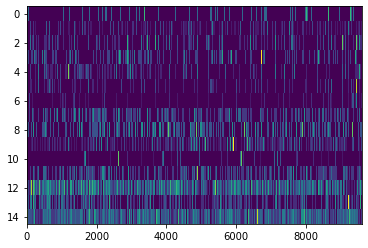

In [133]:
plt.imshow(scaled_firing_long, interpolation='nearest',aspect='auto')

In [155]:
nmf_obj = PCA(n_components = 3).fit(scaled_firing_long.T)
nmf_firing_long = nmf_obj.transform(scaled_firing_long.T).T

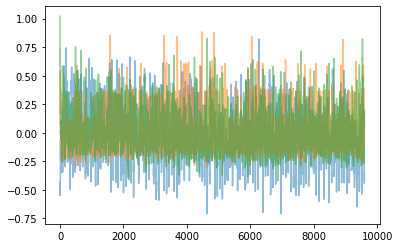

In [156]:
plt.plot(nmf_firing_long.T, alpha = 0.5);

In [157]:
firing_array_temp = firing_array.swapaxes(0,1)
scaled_firing = np.stack([scaler_obj.transform(x.T).T for x in firing_array_temp])
nmf_firing = np.stack([nmf_obj.transform(x.T).T for x in scaled_firing])


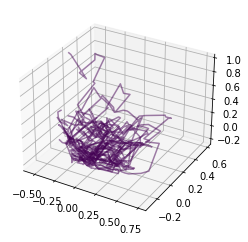

In [160]:
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=1)
colors = cmap(norm(trial_membership))

ax = plt.axes(projection='3d')
for num, trial in enumerate(nmf_firing[:10]):
    ax.plot3D(*trial, c = colors[num], alpha = 0.5)

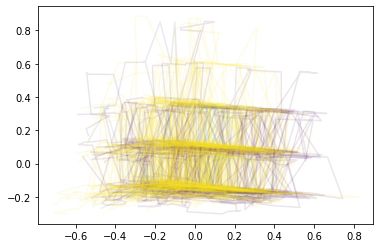

In [164]:
fig,ax = plt.subplots()
for num, trial in enumerate(nmf_firing):
    ax.plot(*trial[:2], c = colors[num], alpha = 0.1)